In [1]:
import sys
import warnings
from config import *

sys.path.append(f"{ROOT}")

warnings.filterwarnings("ignore")

In [6]:
import numpy as np
import pandas as pd
import time
import pickle
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ss_inference.data import SecondaryStructureRawDataset, collate_sequences
from ss_inference.model import NetSurfP2, ConvNet

from pattern_matching.utils import *
from pattern_matching.pattern import *
from pattern_matching.loss import *


from config import DATA
from pgm.data import SequenceData, SequenceStructureData

torch.cuda.is_available()

True

In [7]:
DATASET = "PF07736/russ"

batch_size = 300
q = 21
N = 31
k = 10
lamb_l1b = 0.025
gamma = lamb_l1b/(2*q*N)

## SS3 prediction

In [8]:
dataset = SequenceData(f"{DATA}/{DATASET}", dataset="full")
loader = DataLoader(dataset, batch_size = 100, 
                          shuffle = False)

In [9]:
device = torch.device('cuda')

model_ss3 = NetSurfP2(50, "netsurfp2")
model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/lstm_50feats.h5"))
model_ss3 = model_ss3.to(device)

model_ss3

Model netsurfp2-50

In [ ]:
others, ss8, ss3 = model_ss3.predict(loader)
pickle.dump(ss3, open(f"{DATA}/{DATASET}/ss3.pkl", "wb"))
pickle.dump(ss8, open(f"{DATA}/{DATASET}/ss8.pkl", "wb"))
pickle.dump(others, open(f"{DATA}/{DATASET}/others.pkl", "wb"))

## Pattern Matching

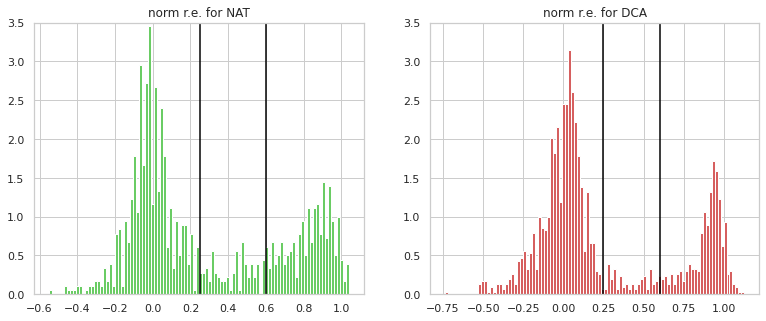

In [10]:
df = pd.read_csv(f"{DATA}/{DATASET}/table_seq.csv")
df["T"] = df["T"].fillna(0)
df["is_active"] = df["norm r.e."].apply(lambda x : int(x >= 0.6))
df["is_inactive"] = df["norm r.e."].apply(lambda x : int(x < 0.25))
df["edca_below_50"] = df["EDCA (rel. to EcCM)"].apply(lambda e : int(e < 50))
df["edca_below_25"] = df["EDCA (rel. to EcCM)"].apply(lambda e : int(e < 25))
keep_idx = df[df.origin != "PROF"].index.values
excluded_idx = df[df.origin == "PROF"].index.values
df = df[df.origin != "PROF"]

plt.figure(figsize = (13,5))
for i, (name, col) in enumerate(zip(['NAT', 'DCA'], ["g","r"])):
    plt.subplot(1, 2, i+1)
    plt.ylim(0,3.5)
    plt.plot([0.25,0.25],[-0.5, 4],c="black")
    plt.plot([0.6,0.6],[-0.5, 4], c="black")
    plt.hist(df[df.origin == name]["norm r.e."], bins = 100, color = col, density = True)
    plt.title(f"norm r.e. for {name}")
plt.show()

In [11]:
seq_hmm = torch.tensor(dataset[0][3]).t()[20:]
torch.save(seq_hmm, f"{DATA}/{DATASET}/hmm.pt")
_, size = seq_hmm.size()

In [12]:
n_patterns, c_patterns, _ =  pickle.load(open(f"{DATA}/{DATASET}/patterns.pkl","rb"))
regexes = []
for x in n_patterns:
    if len(x):
        regexes.append([(i,None,None) for i in x])
size = 150
Q = np.ones((3, size+1, size+1)) * (-np.inf)
e = size
for i in range(size+1):
    Q[:3, i, i+1:] = 0
Q = Q.reshape(1, *Q.shape)

seq_hmm = torch.load(f"{DATA}/{DATASET}/hmm.pt")

matcher = PatternMatching(model_ss3, pattern = regexes[1], Q = Q ,
                          seq_hmm = seq_hmm, ss_hmm = None, 
                          size = size, name = c_patterns[1])
# matcher = PatternMatchingLoss(model_ss3, pattern = regexes[0], Q = Q ,
#                           seq_hmm = seq_hmm, ss_hmm = None, 
#                           size = 100)

In [13]:
t, ls, M, L = [],[],[],[]
len_pat = len(matcher.pattern)
for batch_idx, data in tqdm(enumerate(loader)):
    x = data[0].permute(0,2,1).float()
    torch.cuda.empty_cache()
    m = Matching(x)
    matcher(m)
    t.append(m.t)
    L.append(m.L)
    ls.append(m.ls)
    M.append(m.M)
    del m
t = torch.cat(t,0)
ls= torch.cat(ls,0)
M = torch.cat(M,0)
L = torch.cat(L,0)

31it [00:52,  1.69s/it]


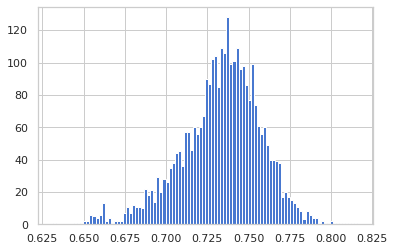

In [14]:
plt.hist([np.exp(m/l) for m, l in zip(M, ls)], bins = 100)
plt.show()

## Computation of the SSQA

In [15]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import *


def where(a, conditioning):
    return a[df[conditioning].index.values]

In [16]:
u = np.array(list(range(30))).reshape(1,1,30)

In [17]:
L.shape

torch.Size([3074, 22, 30])

In [18]:
X = L.view(L.size(0),-1)
X = X[keep_idx]

scaler = StandardScaler()

X_train = where(X, (df.origin == "NAT") & ((df.is_active + df.is_inactive) > 0))
# y_train = df[df.origin == "NAT"]["norm r.e."]
y_train = df[ (df.origin == "NAT") & ((df.is_active + df.is_inactive) > 0)]["is_active"].values
scaler.fit_transform(X_train[np.array(y_train, dtype=bool)])
X_train = scaler.transform(X_train)

X_test = where(X, (df.edca_below_25 == 1) & (df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0))
X_test = scaler.transform(X_test)
# y_test = df[df.origin == "DCA"]["norm r.e."]
y_test = df[(df.edca_below_25 == 1) & (df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)]["is_active"].values

clf = RandomForestClassifier().fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:,1]
df["struct QA"] = clf.predict_proba(scaler.transform(X))[:,1]

acc = y_test.mean()
print(f"Test Accuracy : {acc*100:.2f} %")

train_acc = y_train.mean()
print(f"Train Accuracy : {train_acc*100:.2f} %")

Test Accuracy : 45.88 %
Train Accuracy : 34.65 %


In [19]:
df["P_R"] = -np.array(M)[keep_idx]
edca = df[(df.edca_below_25 == 1) &(df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)]["EDCA (rel. to EcCM)"].values

## Analysis

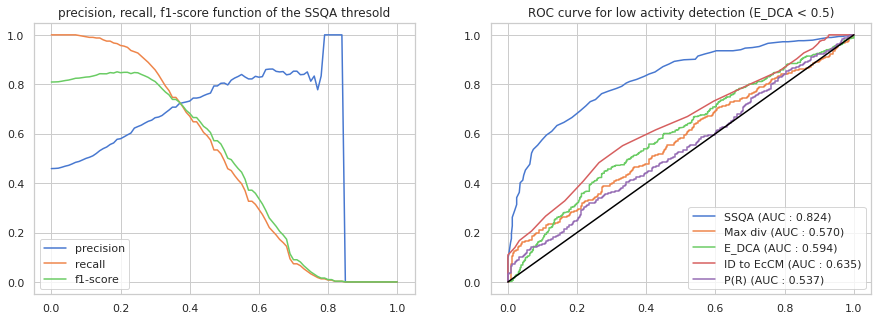

In [20]:
ps, rs, f1s = [],[],[]
for t in np.arange(0.,1.01,0.01):
    p, r, f1, _ = precision_recall_fscore_support(1-y_test, np.array(clf.predict_proba(X_test)[:,1] < t, dtype = int), beta = 2)
    ps.append(p[0]), rs.append(r[0]), f1s.append(f1[0])

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(np.arange(0.,1.01,0.01), ps)
plt.plot(np.arange(0.,1.01,0.01), rs)
plt.plot(np.arange(0.,1.01,0.01), f1s)
plt.legend(["precision", "recall", "f1-score"])
plt.title("precision, recall, f1-score function of the SSQA thresold")

plt.subplot(122)
legs = []
fpr, tpr, _ = roc_curve(1-y_test, -pred)
plt.plot(fpr, tpr)
legs.append(f"SSQA (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y_test, np.abs(X_test).max(-1))
plt.plot(fpr, tpr)
legs.append(f"Max div (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y_test, df[(df.edca_below_25 == 1) &(df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)]["EDCA (rel. to EcCM)"])
plt.plot(fpr, tpr)
legs.append(f"E_DCA (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y_test, -df[(df.edca_below_25 == 1) &(df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)]["ID to EcCM"])
plt.plot(fpr, tpr)
legs.append(f"ID to EcCM (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y_test, df[(df.edca_below_25 == 1) &(df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)]["P_R"])
plt.plot(fpr, tpr)
legs.append(f"P(R) (AUC : {auc(fpr, tpr):.3f})")

plt.plot([0,1], [0,1], c = "black")
plt.legend(legs)
plt.title(f"ROC curve for low activity detection (E_DCA < 0.5)")

plt.show()

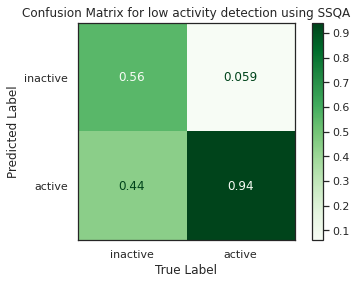

In [21]:
THRES = 0.17
cm = confusion_matrix(1-y_test, np.array(pred < THRES, dtype = int), normalize = "pred")
sns.set(style="white", palette="muted")
cmd = ConfusionMatrixDisplay(cm, display_labels=["inactive","active"])
ax = cmd.plot(cmap='Greens')
plt.title("Confusion Matrix for low activity detection using SSQA")
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

In [241]:
THRES = 0.21
c_acc = 0
for THRES in np.arange(0., 0.8, 0.01):
    cm = confusion_matrix(1-y_test, np.array(pred < THRES, dtype = int), normalize = "pred")
    c_acc = max(c_acc, cm[1,1]/(cm[1,0]+cm[1,1]))
    n_samples = (cm[1,0]*(1-acc)*1000+cm[1,1]*acc*1000)
    print(f"thr = {THRES:.2f} || Acc =  {c_acc*100:.2f}% || Samples = {int(n_samples)}")

thr = 0.00 || Acc =  0.00% || Samples = 292
thr = 0.01 || Acc =  64.91% || Samples = 751
thr = 0.02 || Acc =  64.95% || Samples = 750
thr = 0.03 || Acc =  65.04% || Samples = 749
thr = 0.04 || Acc =  65.18% || Samples = 747
thr = 0.05 || Acc =  65.32% || Samples = 746
thr = 0.06 || Acc =  65.47% || Samples = 744
thr = 0.07 || Acc =  65.76% || Samples = 740
thr = 0.08 || Acc =  65.99% || Samples = 737
thr = 0.09 || Acc =  66.20% || Samples = 735
thr = 0.10 || Acc =  66.44% || Samples = 732
thr = 0.11 || Acc =  66.92% || Samples = 726
thr = 0.12 || Acc =  67.04% || Samples = 717
thr = 0.13 || Acc =  67.51% || Samples = 712
thr = 0.14 || Acc =  67.96% || Samples = 708
thr = 0.15 || Acc =  67.96% || Samples = 702
thr = 0.16 || Acc =  68.32% || Samples = 694
thr = 0.17 || Acc =  68.64% || Samples = 692
thr = 0.18 || Acc =  69.18% || Samples = 683
thr = 0.19 || Acc =  69.27% || Samples = 675
thr = 0.20 || Acc =  69.32% || Samples = 662
thr = 0.21 || Acc =  69.42% || Samples = 654
thr = 0.22 

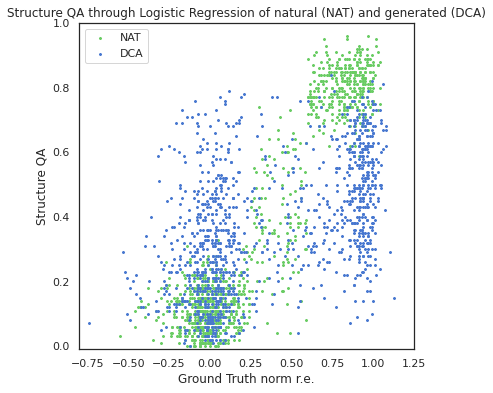

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(df[(df.edca_below_50 == 1) &(df.origin == "NAT")]["norm r.e."].values, 
            df[(df.edca_below_50 == 1) &(df.origin == "NAT")]["struct QA"].values, c="g", marker="x", s=4)
plt.scatter(df[(df.edca_below_50 == 1) &(df.origin == "DCA")]["norm r.e."].values, 
            df[(df.edca_below_50 == 1) &(df.origin == "DCA")]["struct QA"].values, c="b", marker="x", s=4)
plt.legend(["NAT", "DCA"])
plt.xlabel("Ground Truth norm r.e.")
plt.ylabel("Structure QA")
plt.xlim(-0.8, 1.25)
plt.ylim(-0.01, 1.)
plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA)")

plt.show()

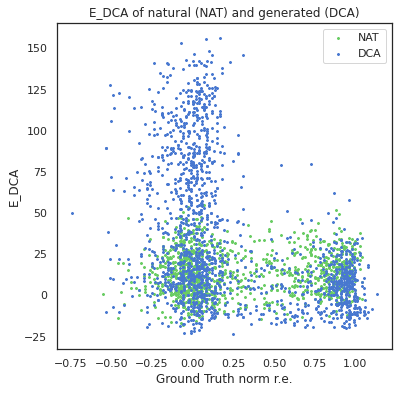

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(df[(df.origin == "NAT")]["norm r.e."].values, 
            df[(df.origin == "NAT")]["EDCA (rel. to EcCM)"].values, s = 4.0, c="g", marker="x")
plt.scatter(df[(df.origin == "DCA")]["norm r.e."].values, 
            df[(df.origin == "DCA")]["EDCA (rel. to EcCM)"].values, s = 4.0, c="b", marker="x")
plt.legend(["NAT", "DCA"])
plt.xlabel("Ground Truth norm r.e.")
plt.ylabel("E_DCA")
# plt.xlim(-0.8, 1.25)
# plt.ylim(-0.01, 0.85)
plt.title("E_DCA of natural (NAT) and generated (DCA)")

plt.show()

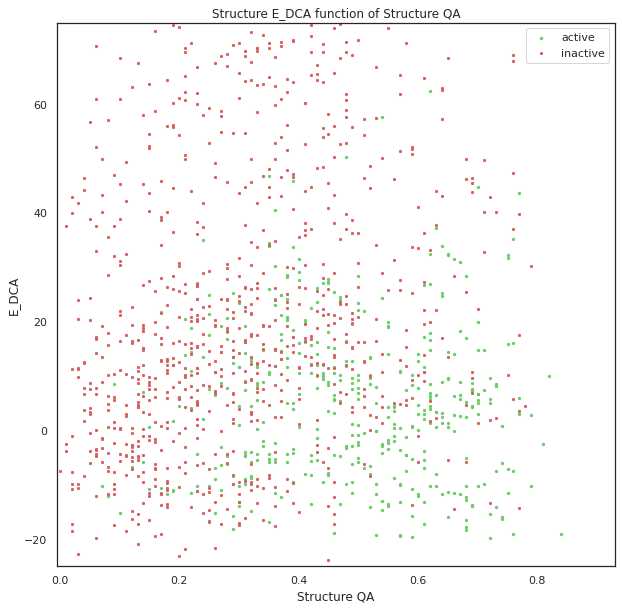

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 1)]["struct QA"].values, 
            df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 1)]["EDCA (rel. to EcCM)"].values, c="g", marker="o", s=5)
plt.scatter(df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 0)]["struct QA"].values, 
            df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 0)]["EDCA (rel. to EcCM)"].values, c="r", marker="x", s=5)
plt.legend(["active", "inactive"], loc = 1)
plt.xlabel("Structure QA")
plt.ylabel("E_DCA")
plt.xlim(-0.005, 0.93)
plt.ylim(-25, 75)
plt.title("Structure E_DCA function of Structure QA")

plt.show()

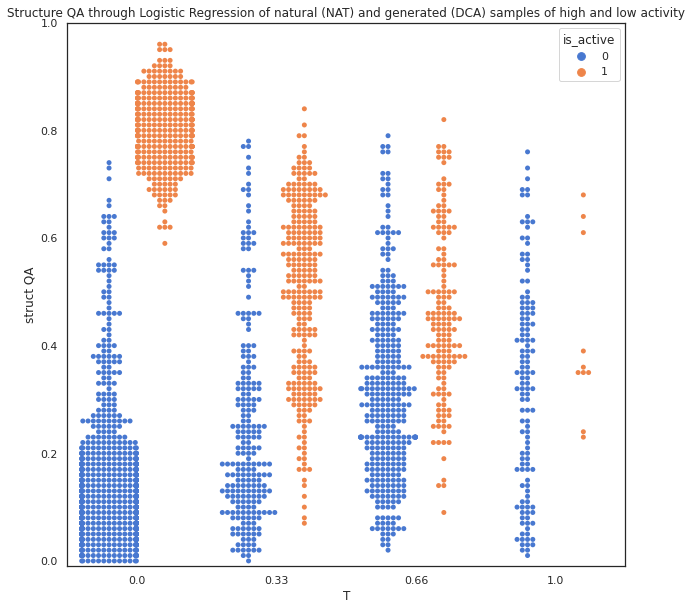

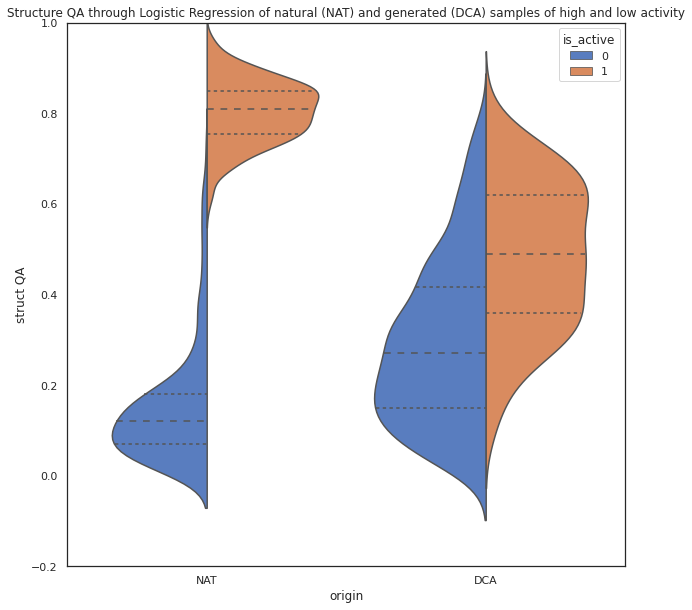

In [25]:
plt.figure(figsize=(10,10))
sns.swarmplot(x = "T", 
               y = "struct QA", 
               hue = "is_active", 
               data = df[df.edca_below_50 == 1], 
               palette = "muted",
               split = True,)
plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA) samples of high and low activity")
plt.ylim(-0.01, 1)
plt.show()

plt.figure(figsize=(10,10))
sns.violinplot(x = "origin", 
               y = "struct QA", 
               hue = "is_active", 
               data = df[df.edca_below_50 == 1], 
               inner = "quartile", 
               palette = "muted",
               split = True,)

plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA) samples of high and low activity")
plt.ylim(-0.2, 1)
plt.show()

## Max divergence

In [26]:
X_test_active, X_test_inactive = X_test[np.array(y_test, dtype=bool)],X_test[np.array(1-y_test, dtype=bool)]
X_train_active, X_train_inactive = X_train[np.array(y_train, dtype=bool)],X_train[np.array(1-y_train, dtype=bool)]
dict_X = {"X_train_active" : X_train_active, "X_train_inactive" : X_train_inactive, 
          "X_test_active" : X_test_active, "X_test_inactive" : X_test_inactive}

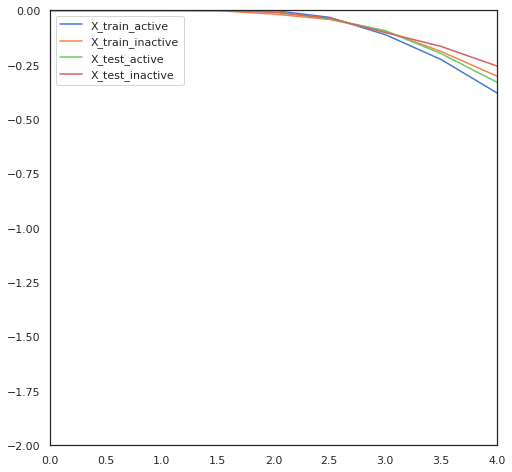

In [27]:
np.abs(X_train_active).max(1)

x = np.linspace(0,5,11)
stds_max = np.zeros((len(dict_X), len(x)))
for i, y in enumerate(dict_X.values()):
    y = np.max(np.abs(y), 1)
    for j, t in enumerate(x):
        stds_max[i, j] = (np.abs(y)>=t).mean()
        
plt.figure(figsize=(8,8))
for s in stds_max:
    plt.plot(x, np.log(s+1e-28))
    plt.xlim(0,4)
    plt.ylim(-2, 0)
plt.legend(dict_X.keys())
plt.show()

## LogReg Divergence

In [28]:
def log_prob(x):
    p = clf.predict_proba(x)[:,1]
    return np.log(p)
        
u = log_prob(X_train[np.array(y_train, dtype=bool)])
m, s = u.mean(), u.std()

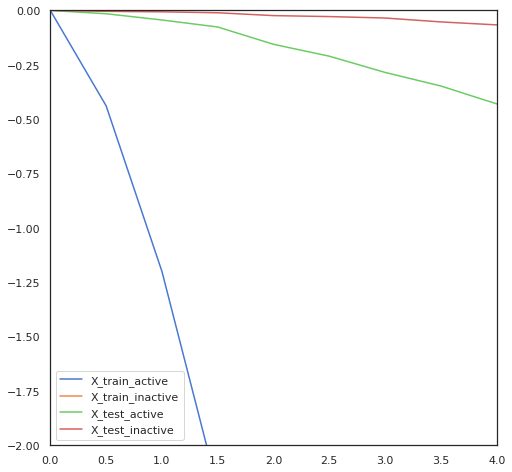

In [29]:
x = np.linspace(0,5,11)
stds_logreg = np.zeros((len(dict_X), len(x)))
for i, y in enumerate(dict_X.values()):
    y_ = (log_prob(y) - m)/s
    for j, t in enumerate(x):
        stds_logreg[i, j] = (np.abs(y_)>=t).mean()
        
plt.figure(figsize=(8,8))
for s in stds_logreg:
    plt.plot(x, np.log(s+1e-28))
    plt.xlim(0,4)
    plt.ylim(-2, 0)
plt.legend(dict_X.keys())
plt.show()

## Kernel Divergence 

In [51]:
X_train = where(X, (df.origin == "NAT") & ((df.is_active + df.is_inactive) > 0))
X_test = where(X, (df.edca_below_25 == 1) &(df.origin == "DCA") & ((df.is_active + df.is_inactive) > 0))

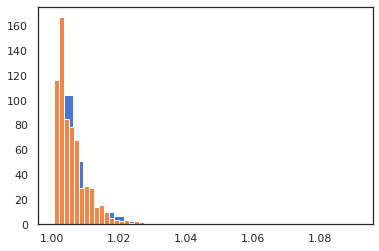

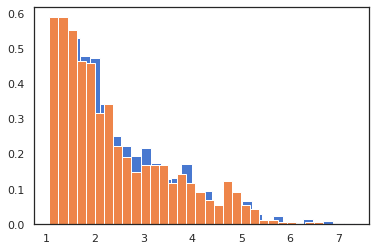

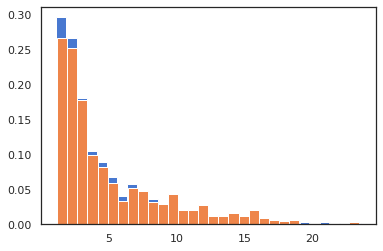

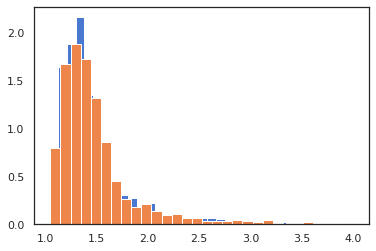

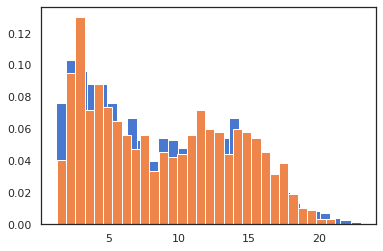

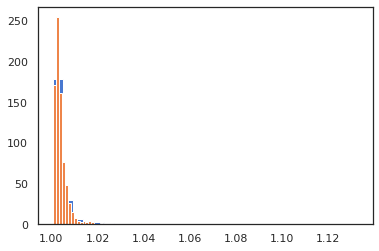

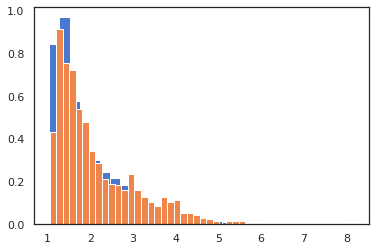

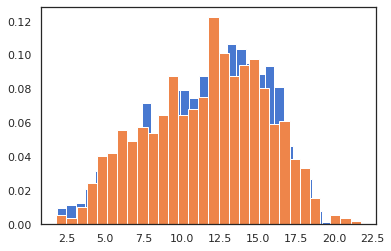

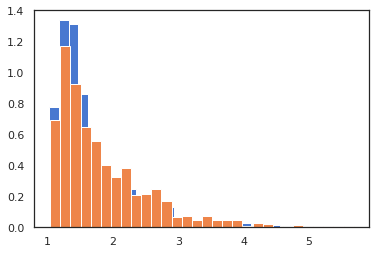

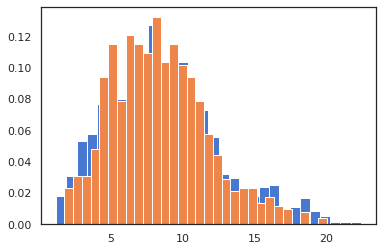

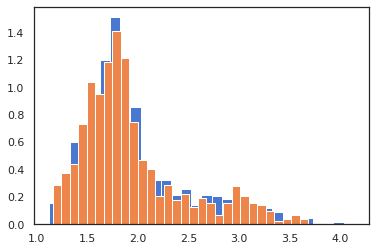

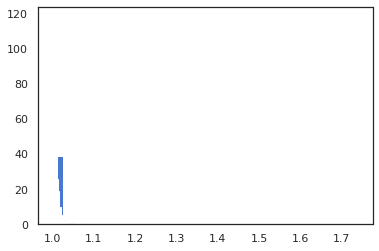

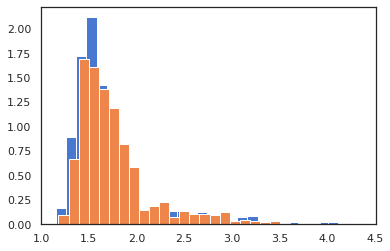

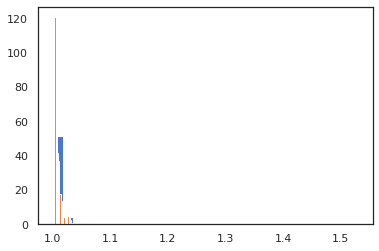

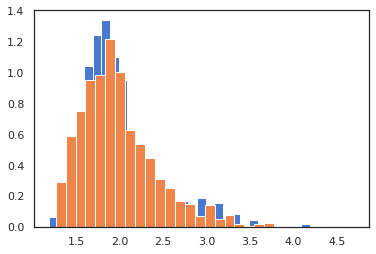

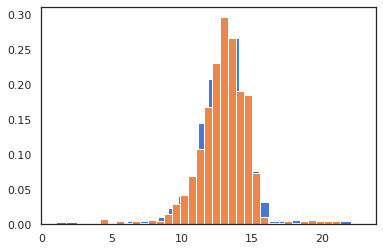

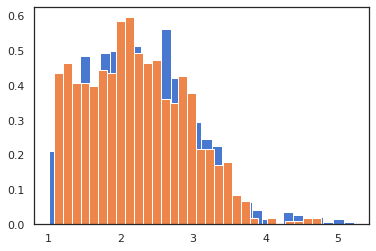

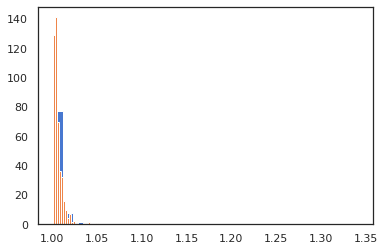

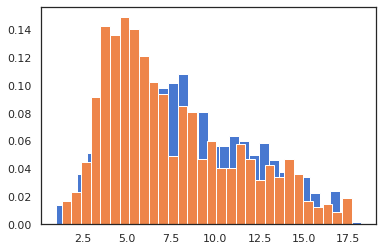

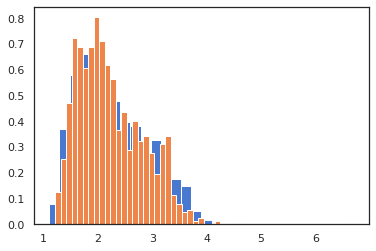

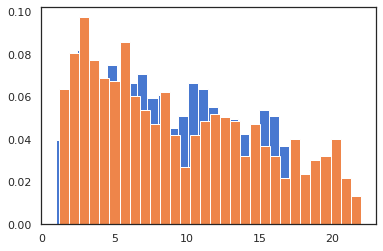

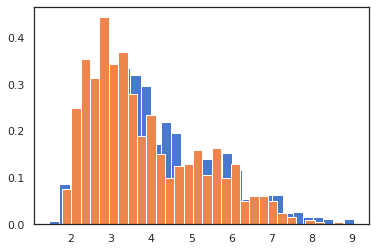

In [57]:
for x1, x2 in zip(X_train.T, X_test.T):
    plt.hist(x1, bins = 30, density=True)
    plt.hist(x2, bins = 30, density=True)
    plt.show()

In [58]:
gms = [KernelDensity(bandwidth=0.2, algorithm='auto', kernel='gaussian').fit(X_train[np.array(y_train, dtype=bool)][:,i:i+1]) for i in range(22)]

gm_scores = np.zeros((len(X), 22))
for k,gm in enumerate(gms):
    X_ = X[:,k]
    gm_scores[:,k] = gm.score_samples(X_.reshape((len(X_), 1))).reshape(len(X_))

gm_scores_max = gm_scores.min(-1)

In [43]:
gm_scores.max()

0.6904993792294283

In [59]:
gm_scores_max_train = where(gm_scores_max, (df.origin == "NAT") & ((df.is_active + df.is_inactive) > 0))
gm_scores_max_test = where(gm_scores_max, (df.edca_below_25 == 1) &(df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)) 

In [60]:
X_test_active, X_test_inactive = gm_scores_max_test[np.array(y_test, dtype = bool)], gm_scores_max_test[np.array(1-y_test, dtype=bool)]
X_train_active, X_train_inactive = gm_scores_max_train[np.array(y_train, dtype=bool)], gm_scores_max_train[np.array(1-y_train, dtype=bool)]
dict_X = {"X_train_active" : X_train_active, "X_train_inactive" : X_train_inactive, 
          "X_test_active" : X_test_active, "X_test_inactive" : X_test_inactive,}

In [61]:
gm_scores_train = where(gm_scores, (df.origin == "NAT") & ((df.is_active + df.is_inactive) > 0))
gm_scores_test = where(gm_scores, (df.edca_below_25 == 1) &(df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)) 

In [35]:
from sklearn.neural_network import MLPClassifier

In [62]:
u = np.array(list(range(30))).reshape(1,1,30)
X = (L*u).sum(-1)
X = X[keep_idx]

scaler = StandardScaler()

X_train = gm_scores_train
# y_train = df[df.origin == "NAT"]["norm r.e."]
y_train = df[ (df.origin == "NAT") & ((df.is_active + df.is_inactive) > 0)]["is_active"].values
scaler.fit_transform(X_train[np.array(y_train, dtype=bool)])
X_train = scaler.transform(X_train)

X_test = gm_scores_test
X_test = scaler.transform(X_test)
# y_test = df[df.origin == "DCA"]["norm r.e."]
y_test = df[(df.edca_below_25 == 1) & (df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)]["is_active"].values

clf = LogisticRegression().fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:,1]
df["struct QA"] = clf.predict_proba(scaler.transform(X))[:,1]

acc = y_test.mean()
print(f"Test Accuracy : {acc*100:.2f} %")

train_acc = y_train.mean()
print(f"Train Accuracy : {train_acc*100:.2f} %")

Test Accuracy : 45.88 %
Train Accuracy : 34.65 %


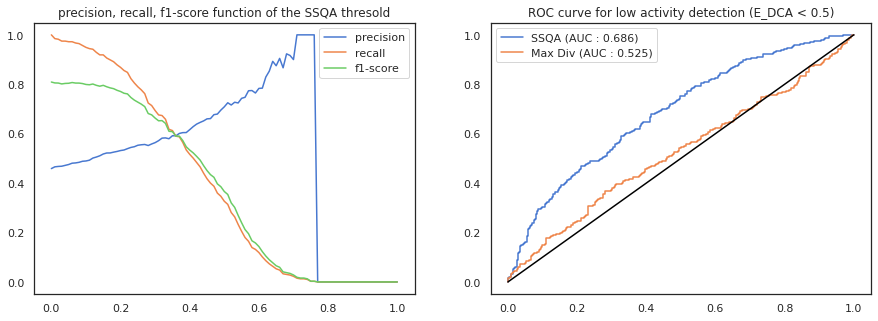

In [63]:
ps, rs, f1s = [],[],[]
for t in np.arange(0.,1.01,0.01):
    p, r, f1, _ = precision_recall_fscore_support(1-y_test, np.array(clf.predict_proba(X_test)[:,1] < t, dtype = int), beta = 2)
    ps.append(p[0]), rs.append(r[0]), f1s.append(f1[0])

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(np.arange(0.,1.01,0.01), ps)
plt.plot(np.arange(0.,1.01,0.01), rs)
plt.plot(np.arange(0.,1.01,0.01), f1s)
plt.legend(["precision", "recall", "f1-score"])
plt.title("precision, recall, f1-score function of the SSQA thresold")

plt.subplot(122)
legs = []
fpr, tpr, _ = roc_curve(1-y_test, -pred)
plt.plot(fpr, tpr)
legs.append(f"SSQA (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y_test, -gm_scores_max_test)
plt.plot(fpr, tpr)
legs.append(f"Max Div (AUC : {auc(fpr, tpr):.3f})")


plt.plot([0,1], [0,1], c = "black")
plt.legend(legs)
plt.title(f"ROC curve for low activity detection (E_DCA < 0.5)")

plt.show()

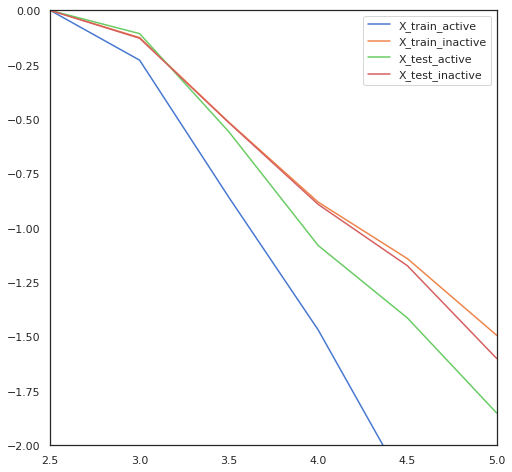

In [64]:
x = np.linspace(0,5,11)
stds_logreg = np.zeros((len(dict_X), len(x)))
for i, y in enumerate(dict_X.values()):
    for j, t in enumerate(x):
        stds_logreg[i, j] = (np.abs(y)>=t).mean()
        
plt.figure(figsize=(8,8))
for s in stds_logreg:
    plt.plot(x, np.log(s+1e-28))
    plt.xlim(2.5,5)
    plt.ylim(-2, 0)
plt.legend(dict_X.keys())
plt.show()

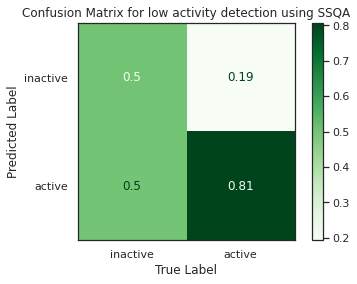

In [201]:
THRES = 0.12
cm = confusion_matrix(1-y_test, np.array(pred < THRES, dtype = int), normalize = "pred")
sns.set(style="white", palette="muted")
cmd = ConfusionMatrixDisplay(cm, display_labels=["inactive","active"])
ax = cmd.plot(cmap='Greens')
plt.title("Confusion Matrix for low activity detection using SSQA")
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

In [202]:
c_acc = 0
for THRES in np.arange(0., 0.8, 0.01):
    cm = confusion_matrix(1-y_test, np.array(pred < THRES, dtype = int), normalize = "pred")
    c_acc = max(c_acc, cm[1,1]/(cm[1,0]+cm[1,1]))
    n_samples = (cm[1,0]*(1-acc)*1000+cm[1,1]*acc*1000)
    print(f"thr = {THRES:.2f} || Acc =  {c_acc*100:.2f}% || Samples = {int(n_samples)}")

thr = 0.00 || Acc =  0.00% || Samples = 292
thr = 0.01 || Acc =  59.02% || Samples = 641
thr = 0.02 || Acc =  59.25% || Samples = 643
thr = 0.03 || Acc =  59.25% || Samples = 628
thr = 0.04 || Acc =  59.56% || Samples = 642
thr = 0.05 || Acc =  60.16% || Samples = 647
thr = 0.06 || Acc =  61.30% || Samples = 658
thr = 0.07 || Acc =  61.30% || Samples = 651
thr = 0.08 || Acc =  61.30% || Samples = 651
thr = 0.09 || Acc =  61.30% || Samples = 646
thr = 0.10 || Acc =  61.30% || Samples = 638
thr = 0.11 || Acc =  61.30% || Samples = 636
thr = 0.12 || Acc =  61.80% || Samples = 639
thr = 0.13 || Acc =  61.80% || Samples = 631
thr = 0.14 || Acc =  61.80% || Samples = 625
thr = 0.15 || Acc =  62.39% || Samples = 627
thr = 0.16 || Acc =  62.39% || Samples = 620
thr = 0.17 || Acc =  62.39% || Samples = 616
thr = 0.18 || Acc =  62.39% || Samples = 612
thr = 0.19 || Acc =  62.39% || Samples = 606
thr = 0.20 || Acc =  62.39% || Samples = 601
thr = 0.21 || Acc =  62.39% || Samples = 596
thr = 0.22 